# 1. Set up

In [1]:
# load data

source('setup.R')

df <- readRDS('nsclc_egfr_pm25_09022015.rds') %>% filter(Predicted_Pop == 'EUR') 

In [2]:
OUTCOME <- "EGFR"
COVAR_OF_INTEREST <- "PM25_cat9"
SECONDARY_MUT <- ifelse(OUTCOME == "EGFR", "KRAS", "EGFR")

COVAR_BASELINE <- c(
    "AGE", "GENDER_NM", "PANEL_VERSION", "STAGE", "YEAR_TEST", "SMOKE", 
    "PC1", "PC2", "PC3", "PC4", "PC5", "LUAD"
)
COVAR_TMB <- "MUTATIONAL_BURDEN"
COVAR_SES <- c("avg_pct_poverty", "avg_med_income", "avg_pct_low_edu")

df_dup <- bind_rows(
    df %>% mutate(group = ifelse(SMOKE, 'Smoked', 'Never smoked')),
    df %>% mutate(group = 'All')
)

# 2. Associatio test

## 2.0 functions

In [3]:
plot_rls_heatmap <- function(rls_df, VAR_OUTCOME, df_dup = NULL, show_n = FALSE, 
                             show_controls = TRUE, control_logic = "sum_zero", horizontal = FALSE) {
    
    # Validate inputs
    if (show_controls && is.null(df_dup)) {
        warning("show_controls=TRUE requires df_dup to be provided. Setting show_controls=FALSE.")
        show_controls <- FALSE
    }
    
    # Create label columns
    rls_df <- rls_df %>%
        mutate(
            log_OR = log(OR),
            OR_label = ifelse(!is.na(OR), sprintf("%.2f", OR), ''),
            pval_fdr = p.adjust(pval, method = "fdr"),
            significance_raw = (pval < 0.05),
            significance_fdr = (pval_fdr < 0.05),
            significance = case_when(
                significance_fdr ~ '**',
                significance_raw ~ '*',
                TRUE ~ ''
            ),
            plot_label = paste0(OR_label, significance)
        )
    
    # Add case counts if requested
    if (show_n && !is.null(df_dup)) {
        n_cases <- df_dup %>%
            group_by(group) %>%
            summarize(across(all_of(VAR_OUTCOME), sum, na.rm = TRUE), .groups = "drop") %>%
            pivot_longer(-group, names_to = "mutation", values_to = "n_cases")
        
        rls_df <- left_join(rls_df, n_cases, by = c("group", "mutation"))
        rls_df$plot_label <- paste0(rls_df$plot_label, "\n(", rls_df$n_cases, ")")
    }
    
    # Calculate and attach control counts if requested
    if (show_controls && !is.null(df_dup)) {

        n_controls <- df_dup %>%
            rowwise() %>%
            mutate(total_mutations = sum(c_across(all_of(VAR_OUTCOME)), na.rm = TRUE)) %>%
            ungroup() %>%
            group_by(group) %>%
            summarize(n_controls = sum(total_mutations == 0, na.rm = TRUE), .groups = "drop")
        
        # Create explicit label mapping in desired order
        group_control_map <- n_controls %>%
            arrange(match(group, c('All', 'Never smoked', 'Smoked'))) %>%
            mutate(group_label = paste0(group, "\n(", n_controls, ")"))
        
        label_vector <- setNames(group_control_map$group_label, group_control_map$group)
        
        # Apply factor order: All → Never smoker → Smoker
        rls_df <- rls_df %>%
            mutate(group = factor(group,
                                  levels = c('All', 'Never smoked', 'Smoked'),
                                  labels = c(label_vector['All'],
                                             label_vector['Never smoked'],
                                             label_vector['Smoked'])))
    } else {
        # No controls shown, fixed order
        rls_df <- rls_df %>%
            mutate(group = factor(group,
                                  levels = c('All', 'Never smoked', 'Smoked')))
    }
    
    # Set mutation factor order & labels
    rls_df$mutation <- factor(
        rls_df$mutation, 
        levels = rev(VAR_OUTCOME),
        labels = rev(c('EGFR', 'L858R', 'del19', 'ins20', 'other'))
    )
    
    # Create the heatmap
    p <- ggplot(rls_df, aes(x = mutation, y = group, fill = log_OR)) + 
        geom_tile(color = "white") +
        geom_text(aes(label = plot_label), 
                  vjust = 0.5, 
                  hjust = 0.5, 
                  size = 7, 
                  color = "black") +
        scale_fill_gradient2(
            low = "#2166AC", 
            mid = "white", 
            high = "#E08214", 
            na.value = "white",
            midpoint = 0, 
            limit = c(min(rls_df$log_OR, na.rm = TRUE), max(rls_df$log_OR, na.rm = TRUE)),
            space = "Lab", 
            name = "Log(OR)"
        ) + 
        theme_minimal(base_size = 20) + 
        labs(
            x = NULL, 
            y = NULL,
            caption = "Significance levels: \n* p < 0.05, ** FDR-adjusted p < 0.05",
            title = glue('Pack-year threshold')
        ) +  
        scale_y_discrete(position = "right") +
        theme(
            plot.caption = element_text(size = 15, hjust = 0),
            legend.position = "none",
            plot.title = element_text(size = 20, hjust = 0.5),
            axis.text.y = element_text(size = if(show_controls) 16 else 20)
        ) 
        if (horizontal == FALSE){
            p <- p + coord_flip()
        }
        
    
    # Print control counts if applicable
    if (show_controls && !is.null(df_dup)) {
        cat("Control counts by group:\n")
        print(n_controls)
        cat("\n")
    }
    
    return(p)
}

## 2.1 Categorical PM2.5, mutation vs no mutation

In [4]:
COVAR_OF_INTEREST = 'PM25_cat9'

formula <- paste('{Y}', "~", paste0(c(COVAR_OF_INTEREST, COVAR_BASELINE, COVAR_TMB, COVAR_SES), collapse = ' + '))
cat(formula)

{Y} ~ PM25_cat9 + AGE + GENDER_NM + PANEL_VERSION + STAGE + YEAR_TEST + SMOKE + PC1 + PC2 + PC3 + PC4 + PC5 + LUAD + MUTATIONAL_BURDEN + avg_pct_poverty + avg_med_income + avg_pct_low_edu

In [5]:
rls_df <- data.frame()

VAR_OUTCOME = c('EGFR', 'EGFR_L858R', 'EGFR_del19', 'EGFR_ins20','EGFR_other')
for(g in c('All', 'Never smoked', 'Smoked')){
    for(Y in VAR_OUTCOME){
        f <- as.formula(glue(formula))
        if(df_dup %>% filter(.data[[Y]] == 1, group == g) %>% nrow() >= 10){
            model <- glm(f, data = df_dup %>% filter(EGFR_mut == 0 | .data[[Y]] == 1, group == g), family = binomial)
            rls <- summary_result(model, COVAR_OF_INTEREST, 3)

        }else{
            rls <- data.frame(param = COVAR_OF_INTEREST, pval = NA, OR = NA, OR_CI_lower= 1, OR_CI_upper = 1, 
                             n = df_dup %>% filter(EGFR_mut == 0 | .data[[Y]] == 1, group == g) %>% nrow())
            
        }
        rls$group <- g
        rls$mutation <- Y
        rls_df <- bind_rows(rls_df, rls)
    }
}
rls_df

,param,pval,OR,OR_CI_lower,OR_CI_upper,n,group,mutation
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
PM25_cat9...1,PM25_cat9,0.0005,1.658,1.245,2.202,2312,All,EGFR
PM25_cat9...2,PM25_cat9,0.0916,1.450,0.936,2.221,2047,All,EGFR_L858R
PM25_cat9...3,PM25_cat9,0.0043,1.841,1.207,2.791,2052,All,EGFR_del19
PM25_cat9...4,PM25_cat9,0.6853,1.195,0.480,2.741,1926,All,EGFR_ins20
PM25_cat9...5,PM25_cat9,0.0038,2.183,1.274,3.681,1971,All,EGFR_other
PM25_cat9...6,PM25_cat9,0.0331,1.685,1.044,2.733,435,Never smoked,EGFR
PM25_cat9...7,PM25_cat9,0.0103,2.312,1.217,4.400,318,Never smoked,EGFR_L858R
PM25_cat9...8,PM25_cat9,0.1747,1.515,0.827,2.754,335,Never smoked,EGFR_del19
PM25_cat9...9,PM25_cat9,0.0503,0.172,0.022,0.833,266,Never smoked,EGFR_ins20


Control counts by group:
# A tibble: 3 × 2
  group        n_controls
  <chr>             <int>
1 All                1889
2 Never smoked        246
3 Smoked             1643



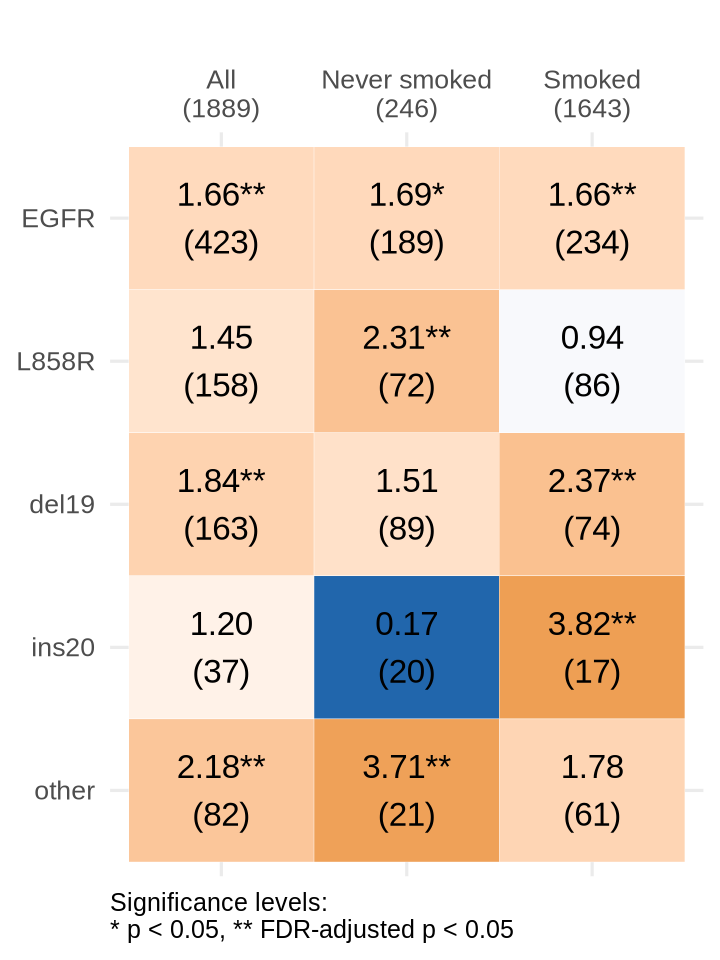

In [6]:
set_fig_size(w = 6, h = 8)
p <- plot_rls_heatmap(rls_df, VAR_OUTCOME, df_dup, show_n = TRUE) + ggtitle('')
p
ggsave("result/subtype_heatmap_DFCI_Profile.pdf", plot = p, width = 6, height = 8)

In [7]:
n_cases <- df_dup %>%
            group_by(group) %>%
            summarize(across(all_of(VAR_OUTCOME), sum), .groups = "drop") %>%
            pivot_longer(-group, names_to = "mutation", values_to = "n_cases")
smry <- rls_df %>% left_join(n_cases, by = c("group", "mutation")) %>% 
    mutate(n_contrl = n - n_cases) %>% 
    mutate(
        OR = round(OR,2), 
        OR_CI_lower = round(OR_CI_lower,2), 
        OR_CI_upper = round(OR_CI_upper,2),
        CI = glue('{OR_CI_lower}-{OR_CI_upper}'),
        pval = formatC(pval, format = "g", digits = 3)
    ) %>% select(
        group,
        mutation,
        n_cases,
        n_contrl,
        OR,
        CI,
        pval
    ) 
smry
smry %>% write_tsv('result/profile-mut-subtype.tsv')

group,mutation,n_cases,n_contrl,OR,CI,pval
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<glue>,<chr>
All,EGFR,423,1889,1.66,1.25-2.2,0.0005
All,EGFR_L858R,158,1889,1.45,0.94-2.22,0.0916
All,EGFR_del19,163,1889,1.84,1.21-2.79,0.0043
All,EGFR_ins20,37,1889,1.20,0.48-2.74,0.685
All,EGFR_other,82,1889,2.18,1.27-3.68,0.0038
Never smoked,EGFR,189,246,1.69,1.04-2.73,0.0331
Never smoked,EGFR_L858R,72,246,2.31,1.22-4.4,0.0103
Never smoked,EGFR_del19,89,246,1.51,0.83-2.75,0.175
Never smoked,EGFR_ins20,20,246,0.17,0.02-0.83,0.0503
